<a href="https://colab.research.google.com/github/Bhandari007/Pnemonia_Classification/blob/main/XRAY_IMAGE_CLASSIFICATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# `Problem Statement`
> Given a dataset of chest X-ray images, the task is to classify whether a patient has penumonia or not. The desired outcome is to develop a model that can assist in the diagnosis of pneumonia. The model should have a `high recall` to minimize the false negatives and a `high specificity` to minimize the false positives.




# `Choice of Models`
> Based on the journal, https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0256630, I will be using **ResNet** and **DenseNet**, to train on the given dataset.


# `Mount Drive`

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Downloading helper functions
!wget https://raw.githubusercontent.com/Bhandari007/Pnemonia_Classification/main/helper_functions.py

--2023-05-05 02:32:24--  https://raw.githubusercontent.com/Bhandari007/Pnemonia_Classification/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-05-05 02:32:24 (87.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



# Importing necessary libraries

In [ ]:
import os
import matplotlib.pyplot as plt
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir, make_confusion_matrix 

In [ ]:
ROOT_DIR = "drive/MyDrive/NAMMI_ASSIGNMENT/archive.zip"
TRAIN_DIR = "chest_xray/train"
TEST_DIR = "chest_xray/test"
VAL_DIR = "chest_xray/val"

In [ ]:
unzip_data(ROOT_DIR)

# `EXPLORING THE DATA`

## Number of images 

In [ ]:
print("\t\t TRAIN")
walk_through_dir(TRAIN_DIR)
print("\t\t VAL")
walk_through_dir(VAL_DIR)
print("\t\t TEST")
walk_through_dir(TEST_DIR)

		 TRAIN
There are 2 directories and 0 images in 'chest_xray/train'.
There are 0 directories and 3875 images in 'chest_xray/train/PNEUMONIA'.
There are 0 directories and 1341 images in 'chest_xray/train/NORMAL'.
		 VAL
There are 2 directories and 0 images in 'chest_xray/val'.
There are 0 directories and 8 images in 'chest_xray/val/PNEUMONIA'.
There are 0 directories and 8 images in 'chest_xray/val/NORMAL'.
		 TEST
There are 2 directories and 0 images in 'chest_xray/test'.
There are 0 directories and 390 images in 'chest_xray/test/PNEUMONIA'.
There are 0 directories and 234 images in 'chest_xray/test/NORMAL'.


**Insight: Here we can see that we have 3875 X-Ray images belonging to `PNEUMONIA` and 1341 total X-Ray images which are `NORMAL`. So, our model will assumed to have more ability to correctly classify the X-RAY images of `PNEUMONIA`**.

## EXAMPLE IMAGES

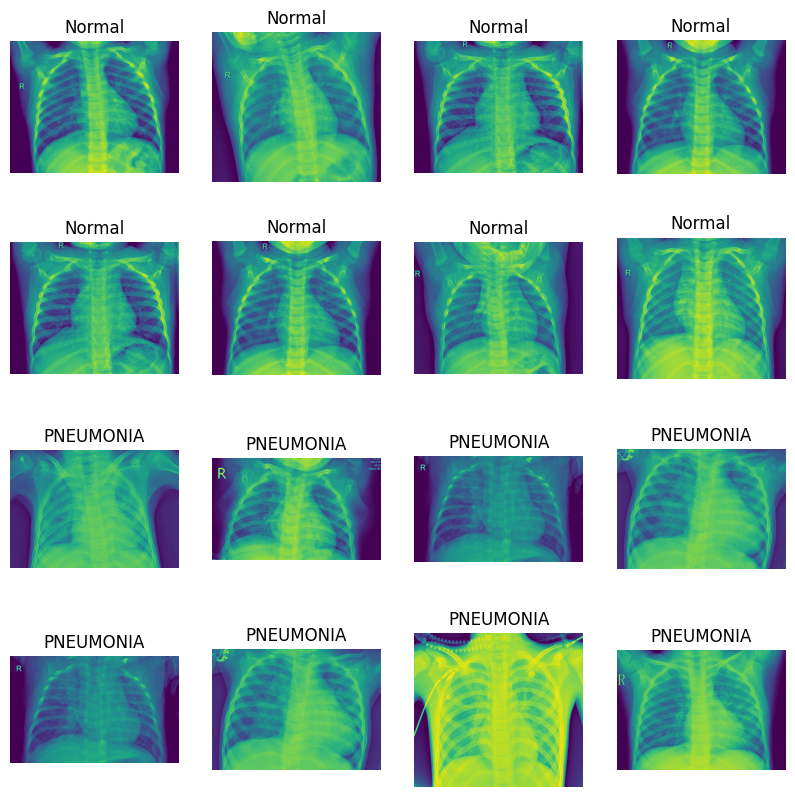

In [ ]:
# Get a list of all the normal and abnormal image filenames
normal_images = os.listdir(os.path.join(TRAIN_DIR, "NORMAL"))
abnormal_images = os.listdir(os.path.join(TRAIN_DIR, "PNEUMONIA"))

# Choose 8 normal and 8 abnormal images randomly
random_normal_images = random.sample(normal_images, 8)
random_abnormal_images = random.sample(abnormal_images, 8)

# Create a 4x4 grid of subplots
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))

# Loop through the subplots and plot the images
for i in range(4):
  for j in range(4):
    if i < 2:
      # Plot the normal images in the top row
      img = plt.imread(os.path.join(TRAIN_DIR, "NORMAL", random_normal_images[i*2+j]))
      ax[i, j].imshow(img)
      ax[i, j].set_title("Normal")
    else:
      # Plot the abnormal images in the bottom row
      img = plt.imread(os.path.join(TRAIN_DIR, "PNEUMONIA", random_abnormal_images[(i-2)*2+j]))
      ax[i, j].imshow(img)
      ax[i, j].set_title("PNEUMONIA")

    ax[i, j].axis("off")

# Display the grid of images
plt.show()

# `Creating Data Loaders`

In [ ]:
IMG_SHAPE = (224, 224)

In [ ]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(TRAIN_DIR,
                                               image_size = IMG_SHAPE,
                                               label_mode='binary')

test_data = tf.keras.preprocessing.image_dataset_from_directory(TEST_DIR,
                                               image_size = IMG_SHAPE,
                                               shuffle=False,
                                               label_mode='binary')

val_data = tf.keras.preprocessing.image_dataset_from_directory(VAL_DIR,
                                               image_size = IMG_SHAPE,
                                               shuffle=False,
                                               label_mode='binary')

Found 5216 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Found 16 files belonging to 2 classes.


In [ ]:
# class names
train_data.class_names

['NORMAL', 'PNEUMONIA']

# `Experiment Phase I`
The steps that I will be following the upcoming section can be outlined as:

* Create a ResNet model.
* Compile our model
* Feature extraction
* Evaluate
* Perform same for DenseNet Model

# `Model 0: ResNet`

In [ ]:
resnet_base_model = tf.keras.applications.resnet50.ResNet50(weights='imagenet',include_top=False)
resnet_base_model.trainable = False

inputs = layers.Input(shape=(224,224,3),name="input_layer")
x = layers.Rescaling(1./255)(inputs)
x = resnet_base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(1, activation = 'sigmoid', name='output_layer')(x)
model = tf.keras.Model(inputs, outputs)

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
# Compile 

model.compile(loss="binary_crossentropy",
              optimizer = tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit
resnet_base_model_history = model.fit(train_data,
                          epochs = 5,
                          validation_data = val_data,
                          callbacks=[create_tensorboard_callback("naami", "resnet_base_model")])

Saving TensorBoard log files to: naami/resnet_base_model/20230505-023319
Epoch 1/5
163/163 [==============================] - 47s 198ms/step - loss: 0.1867 - accuracy: 0.9262 - val_loss: 0.6112 - val_accuracy: 0.6875
Epoch 2/5
163/163 [==============================] - 31s 181ms/step - loss: 0.0953 - accuracy: 0.9649 - val_loss: 0.3937 - val_accuracy: 0.7500
Epoch 3/5
163/163 [==============================] - 31s 184ms/step - loss: 0.0782 - accuracy: 0.9711 - val_loss: 0.2712 - val_accuracy: 0.9375
Epoch 4/5
163/163 [==============================] - 31s 180ms/step - loss: 0.0699 - accuracy: 0.9741 - val_loss: 0.4151 - val_accuracy: 0.6875
Epoch 5/5
163/163 [==============================] - 31s 182ms/step - loss: 0.0607 - accuracy: 0.9774 - val_loss: 0.2944 - val_accuracy: 0.9375


In [ ]:
model.evaluate(test_data)

20/20 [==============================] - 3s 126ms/step - loss: 0.5146 - accuracy: 0.8061


[0.5146406292915344, 0.8060897588729858]

## Loss Curves

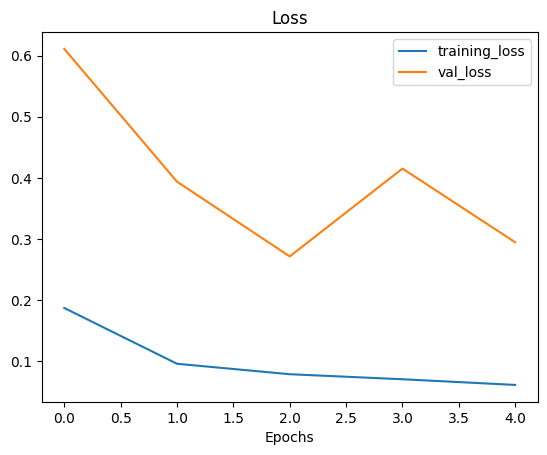

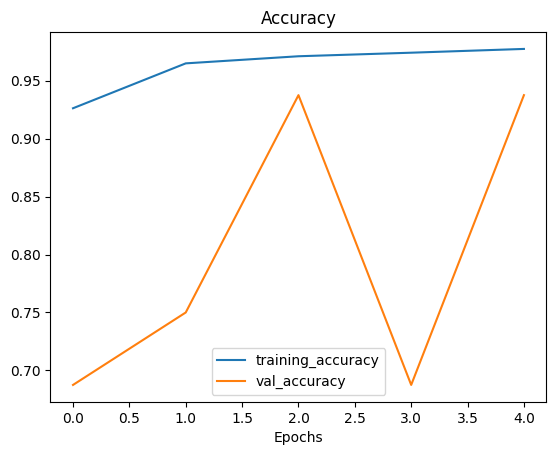

In [ ]:
plot_loss_curves(resnet_base_model_history)

## `Findings`:

Based on the training and validation results, it seems like the model is performing well, achieveing an accuracy of over 97% on the training set and over 93% on the validation set. However, the accuracy on the test set is lower, at round 82%.

This indicates that the model is `overfitting` to the training data and not generalizing well to new data. The possible solutions could be `increasing the size of the dataset`, adjusting the learning rate, adding regulariztion techniques like dropout or weight decay.

To properly evaluate the performance of the model, I will now use `precision, recall and F1 Score` to get a more complete picture of how well the model is performing.

## Evaluation Metrics

In [ ]:
predictions = model.predict(test_data)
predicted_labels = [0 if prediction < 0.5 else 1 for prediction in predictions]

20/20 [==============================] - 4s 167ms/step


In [ ]:
true_labels = []
for batch_images, batch_labels in test_data.unbatch():
    true_labels.append(batch_labels.numpy())

In [ ]:
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(true_labels,predicted_labels)
sklearn_accuracy

0.8060897435897436

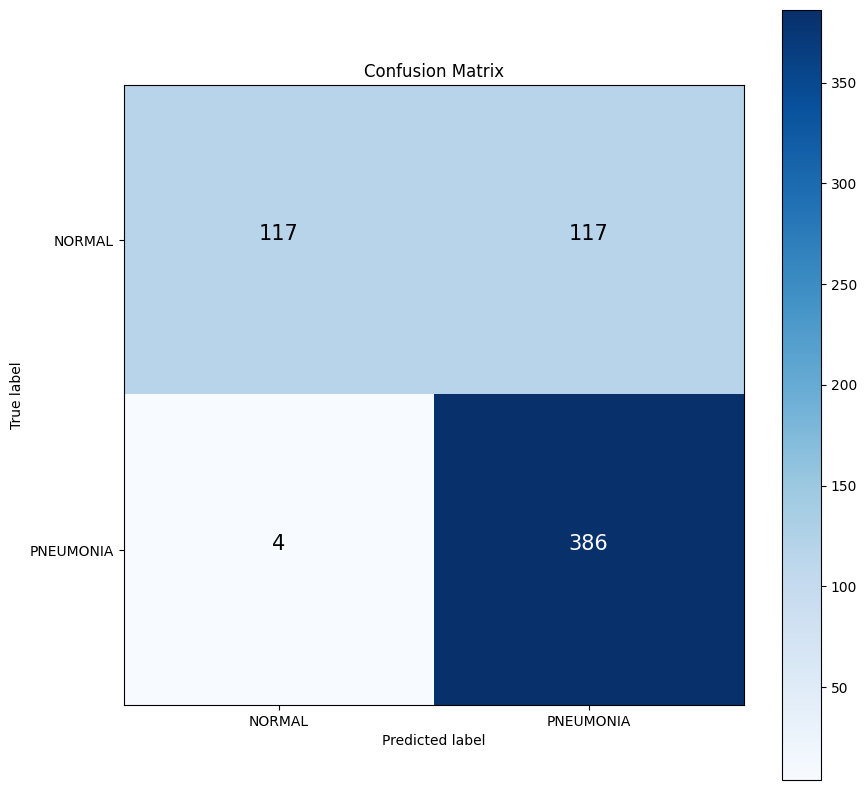

In [ ]:
make_confusion_matrix(
    true_labels,
    predicted_labels,
    classes = test_data.class_names
)

In [ ]:
cm = confusion_matrix(true_labels,predicted_labels)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
print("Specificity:", specificity)
print("Sensitivity:", sensitivity)

Specificity: 0.5
Sensitivity: 0.9897435897435898


### `ROC Curves`

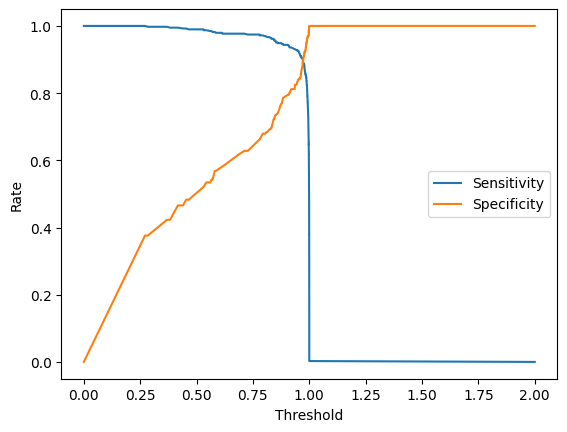

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(true_labels, predictions)

sensitivity = tpr
specificity = 1 - fpr

# plot sensitivity and specificity against threshold
plt.plot(thresholds, sensitivity, label='Sensitivity')
plt.plot(thresholds, specificity, label='Specificity')
plt.xlabel('Threshold')
plt.ylabel('Rate')
plt.legend()
plt.show()

## `Conclusion`

The model have high sensitity (TPR) but low specificity (TNR). This means that the model is good at identifying positive cases of penumonia but also is classifiying some false positives (i.e normal cases that are incorrectly classified as pneumonia)

# `Model 1: DenseNet`

In [ ]:
dense_net_base_model = tf.keras.applications.densenet.DenseNet121(
    include_top=False,
    weights='imagenet',
)
dense_net_base_model.trainable = False

inputs = layers.Input(shape=(224,224,3),name="input_layer")
x = layers.Rescaling(1./255)(inputs)
x = resnet_base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(1, activation = 'sigmoid', name='output_layer')(x)
model_1 = tf.keras.Model(inputs, outputs)

29084464/29084464 [==============================] - 1s 0us/step


In [ ]:
# Compile 

model_1.compile(loss="binary_crossentropy",
              optimizer = tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit
dense_net_base_model_history = model_1.fit(train_data,
                          epochs = 5,
                          validation_data = val_data,
                          callbacks=[create_tensorboard_callback("naami", "dense_net_base_model")])

Saving TensorBoard log files to: naami/dense_net_base_model/20230505-023717
Epoch 1/5
163/163 [==============================] - 36s 186ms/step - loss: 0.2112 - accuracy: 0.9151 - val_loss: 0.4316 - val_accuracy: 0.8125
Epoch 2/5
163/163 [==============================] - 31s 181ms/step - loss: 0.1033 - accuracy: 0.9611 - val_loss: 0.5354 - val_accuracy: 0.6875
Epoch 3/5
163/163 [==============================] - 31s 182ms/step - loss: 0.0857 - accuracy: 0.9676 - val_loss: 0.5687 - val_accuracy: 0.6250
Epoch 4/5
163/163 [==============================] - 45s 264ms/step - loss: 0.0730 - accuracy: 0.9718 - val_loss: 0.7849 - val_accuracy: 0.6250
Epoch 5/5
163/163 [==============================] - 36s 210ms/step - loss: 0.0647 - accuracy: 0.9770 - val_loss: 0.3186 - val_accuracy: 0.9375


## Loss Curves:

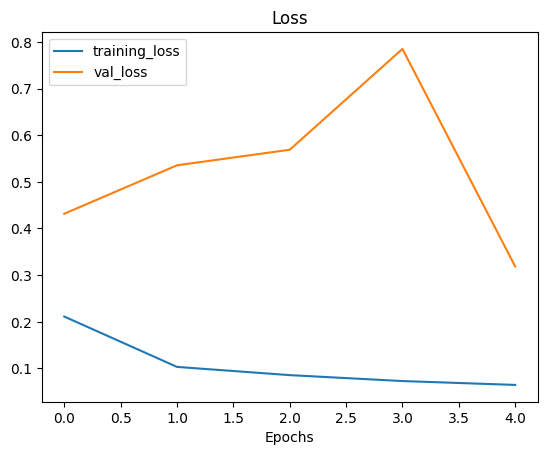

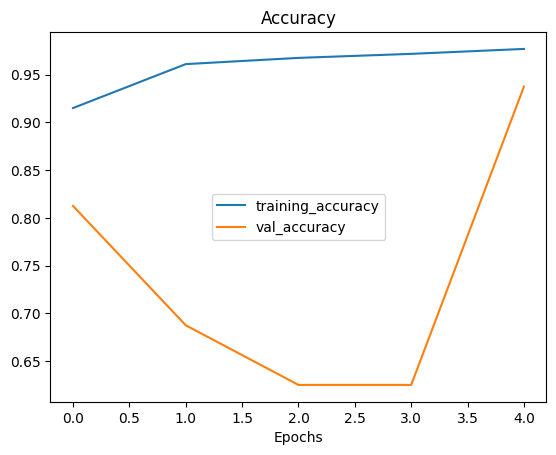

In [ ]:
plot_loss_curves(dense_net_base_model_history)

In [ ]:
model_1.evaluate(test_data)

20/20 [==============================] - 3s 155ms/step - loss: 0.4657 - accuracy: 0.8205


[0.46567869186401367, 0.8205128312110901]

## `Findings`:

Based on the training and validation results, it seems like the model is performing well, achieveing an accuracy of over 97% on the training set and over 87% on the validation set. However, the accuracy on the test set is lower, at round 80%.

The DenseNet seems to perform less effective than ResNet architectire.

To properly evaluate the performance of the model, I will now use `precision, recall and F1 Score` to get a more complete picture of how well the model is performing.

## `Evaluation Metrics`

In [ ]:
predictions = model_1.predict(test_data)
predicted_labels = [0 if prediction < 0.5 else 1 for prediction in predictions]

20/20 [==============================] - 6s 210ms/step


In [ ]:
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(true_labels,predicted_labels)
sklearn_accuracy

0.8205128205128205

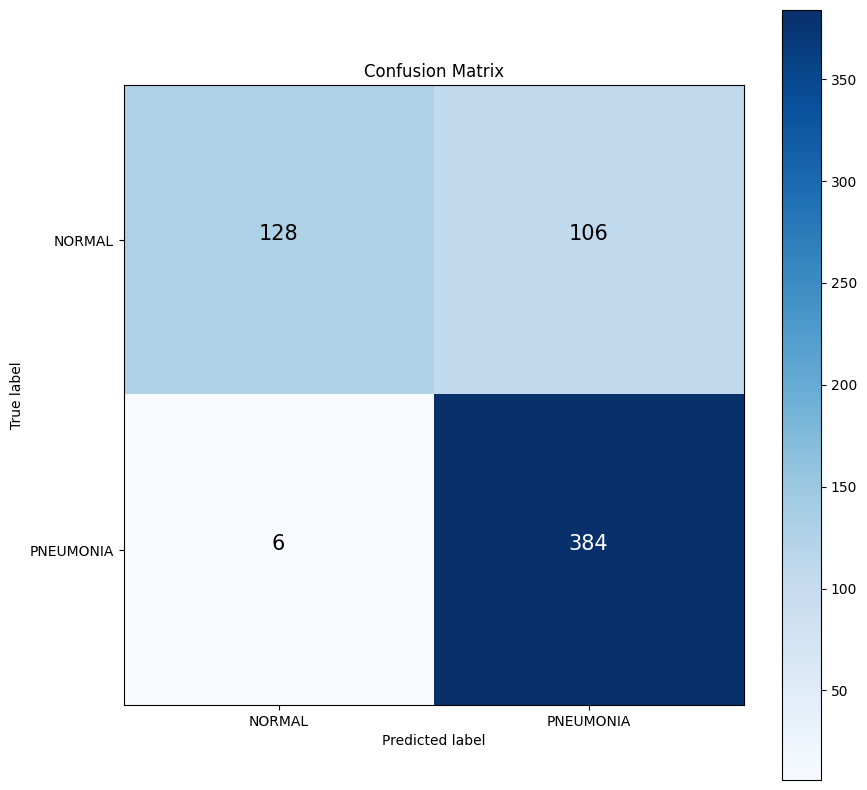

In [ ]:
make_confusion_matrix(
    true_labels,
    predicted_labels,
    classes = test_data.class_names
)

In [ ]:
cm = confusion_matrix(true_labels,predicted_labels)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
print("Specificity:", specificity)
print("Sensitivity:", sensitivity)

Specificity: 0.5470085470085471
Sensitivity: 0.9846153846153847


## `Conclusion`

The model have high perfect sensitity (TPR) but very low specificity (TNR). This means that the model is perfect at identifying positive cases of penumonia but is  bad at classifiying  false positives (i.e normal cases that are incorrectly classified as pneumonia)

# Experimentation Phase II:

After the results shown by ResNet and DenseNet. It is clear that both the models so far are suffering from overfitting problem. To tackle this issue, I will now perform data augmentation and train on both these models.

# `Data Augmentation Layer` 

In [ ]:
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.Rescaling(1./255)
], name='data_augmentation')

# `Model 0.1: ResNet with Data Augmentation`

In [ ]:
resnet_base_model = tf.keras.applications.resnet50.ResNet50(weights='imagenet',include_top=False)
resnet_base_model.trainable = False

inputs = layers.Input(shape=(224,224,3),name="input_layer")
x = data_augmentation(inputs)
x = resnet_base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(1, activation = 'sigmoid', name='output_layer')(x)
model_0_1 = tf.keras.Model(inputs, outputs)

In [ ]:
# Compile 

model_0_1.compile(loss="binary_crossentropy",
              optimizer = tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit
resnet_base_model_history = model_0_1.fit(train_data,
                          epochs = 5,
                          validation_data = val_data,
                          callbacks=[create_tensorboard_callback("naami", "resnet_data_aug")])

Saving TensorBoard log files to: naami/resnet_data_aug/20230505-024034
Epoch 1/5
163/163 [==============================] - 45s 230ms/step - loss: 0.1711 - accuracy: 0.9331 - val_loss: 0.4797 - val_accuracy: 0.6875
Epoch 2/5
163/163 [==============================] - 48s 272ms/step - loss: 0.0943 - accuracy: 0.9651 - val_loss: 0.3684 - val_accuracy: 0.7500
Epoch 3/5
163/163 [==============================] - 48s 284ms/step - loss: 0.0791 - accuracy: 0.9686 - val_loss: 0.3541 - val_accuracy: 0.8125
Epoch 4/5
163/163 [==============================] - 43s 254ms/step - loss: 0.0684 - accuracy: 0.9722 - val_loss: 0.5165 - val_accuracy: 0.6250
Epoch 5/5
163/163 [==============================] - 35s 206ms/step - loss: 0.0597 - accuracy: 0.9776 - val_loss: 0.2386 - val_accuracy: 0.9375


In [ ]:
model_0_1.evaluate(test_data)

20/20 [==============================] - 3s 119ms/step - loss: 0.4559 - accuracy: 0.8349


[0.4559115767478943, 0.8349359035491943]

### `Loss Curves`

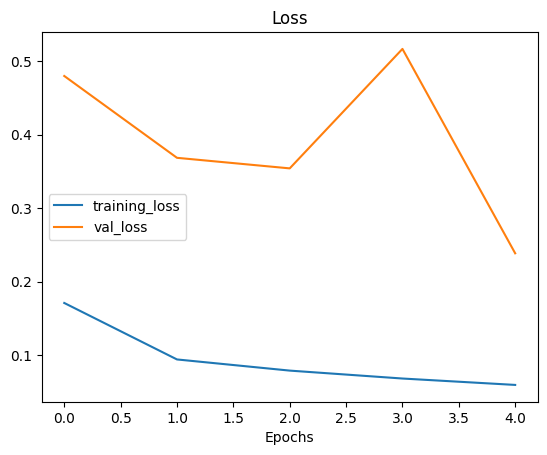

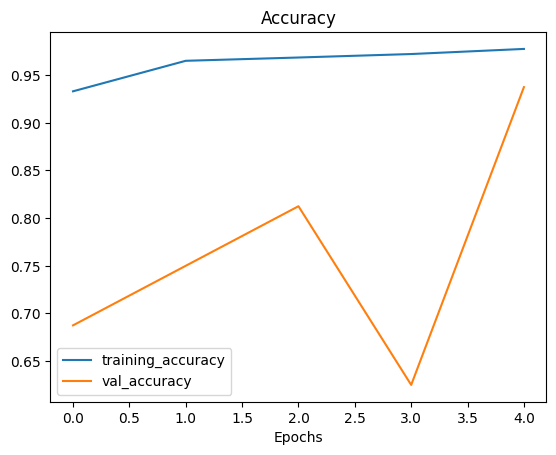

In [ ]:
plot_loss_curves(resnet_base_model_history)

## `Findings`:
After applying data augmentation on the ResNet model, we can see that the validation accuracy has dropped significantly from 0.9375 to 0.8125, which suggests that the model is not performing as well as before. The training accuracy has remained similar to the previous model but the validation loss has increased, indicating that the model is overfitting on the training data.




## `Evaluation Metrics`

In [ ]:
predictions = model_0_1.predict(test_data)
predicted_labels = [0 if prediction < 0.5 else 1 for prediction in predictions]

20/20 [==============================] - 6s 195ms/step


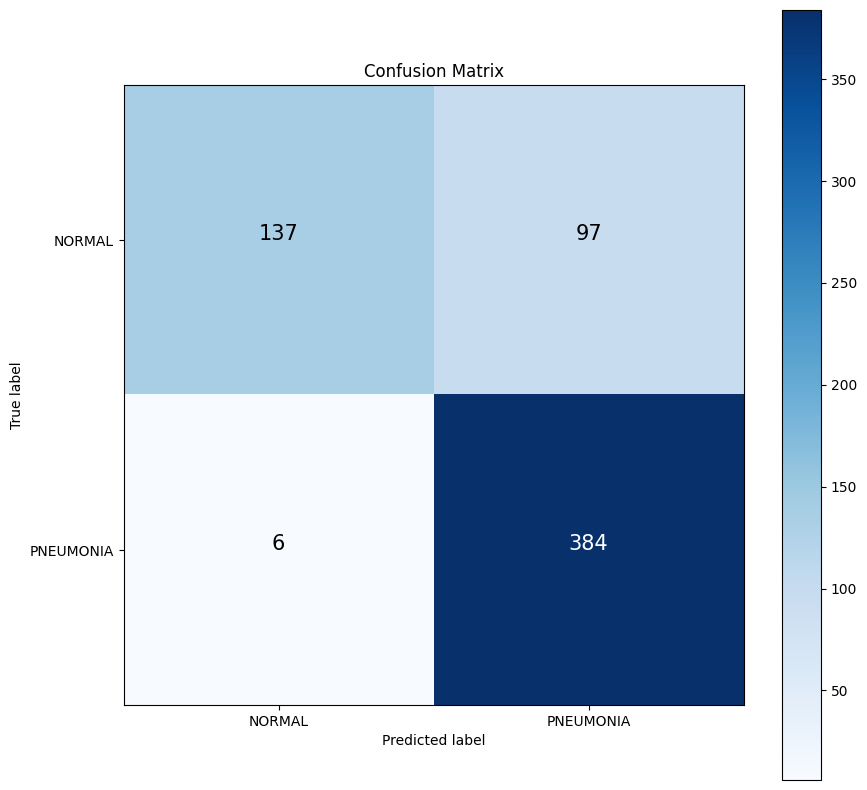

In [ ]:
make_confusion_matrix(
    true_labels,
    predicted_labels,
    classes = test_data.class_names
)

In [ ]:
cm = confusion_matrix(true_labels,predicted_labels)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
print("Specificity:", specificity)
print("Sensitivity:", sensitivity)

Specificity: 0.5854700854700855
Sensitivity: 0.9846153846153847


## `Conclusion`:
the sensitivity remains high, meaning that the model is correctly identifying a large proportion of positive cases. But the specificity is still low, indicating that the model is falsely classifying some negative cases as positive. This could be due to overfitting or insufficient data augmentation.


# `Model 1.1 : DenseNet with Data Augmentation`

In [ ]:
dense_net_base_model = tf.keras.applications.densenet.DenseNet121(
    include_top=False
)
dense_net_base_model.trainable = False

inputs = layers.Input(shape=(224,224,3),name="input_layer")
x = data_augmentation(inputs)
x = dense_net_base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(1, activation = 'sigmoid', name='output_layer')(x)
model_1_1 = tf.keras.Model(inputs, outputs)

In [ ]:
# Compile 

model_1_1.compile(loss="binary_crossentropy",
              optimizer = tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit
dense_net_base_model_history = model_1_1.fit(train_data,
                          epochs = 5,
                          validation_data = val_data,
                          callbacks=[create_tensorboard_callback("naami", "dense_net_data_aug")])

Saving TensorBoard log files to: naami/dense_net_data_aug/20230505-024434
Epoch 1/5
163/163 [==============================] - 70s 336ms/step - loss: 0.3439 - accuracy: 0.8528 - val_loss: 1.2801 - val_accuracy: 0.5625
Epoch 2/5
163/163 [==============================] - 44s 263ms/step - loss: 0.1783 - accuracy: 0.9369 - val_loss: 0.9298 - val_accuracy: 0.6250
Epoch 3/5
163/163 [==============================] - 41s 236ms/step - loss: 0.1440 - accuracy: 0.9500 - val_loss: 0.8804 - val_accuracy: 0.6250
Epoch 4/5
163/163 [==============================] - 38s 220ms/step - loss: 0.1282 - accuracy: 0.9563 - val_loss: 0.8458 - val_accuracy: 0.6250
Epoch 5/5
163/163 [==============================] - 51s 288ms/step - loss: 0.1142 - accuracy: 0.9628 - val_loss: 0.9674 - val_accuracy: 0.6250


In [ ]:
model_1_1.evaluate(test_data)

20/20 [==============================] - 5s 239ms/step - loss: 0.6412 - accuracy: 0.7708


[0.6412070989608765, 0.7708333134651184]

### Plot Loss Curves

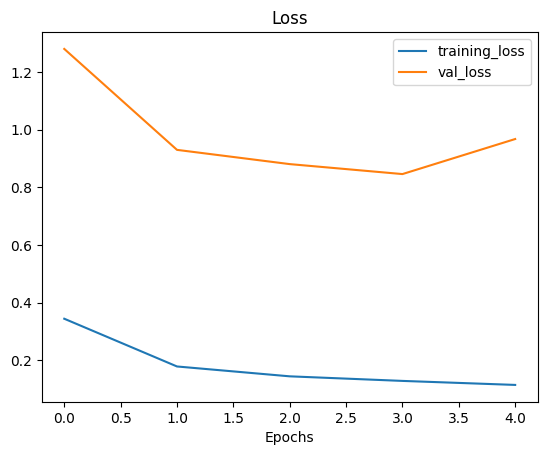

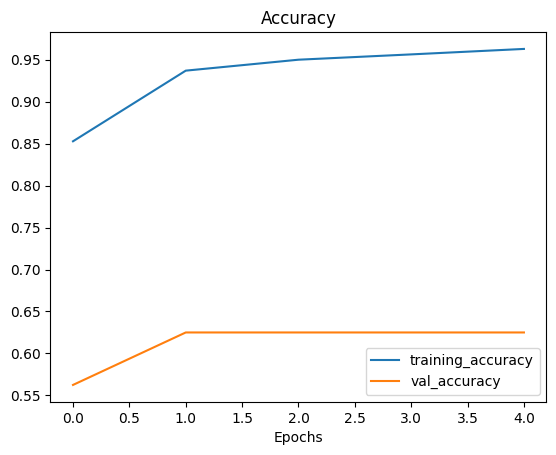

In [ ]:
plot_loss_curves(dense_net_base_model_history)

### `Evaluation Metrics`

In [ ]:
predictions = model_1_1.predict(test_data)
predicted_labels = [0 if prediction < 0.5 else 1 for prediction in predictions]

20/20 [==============================] - 8s 294ms/step


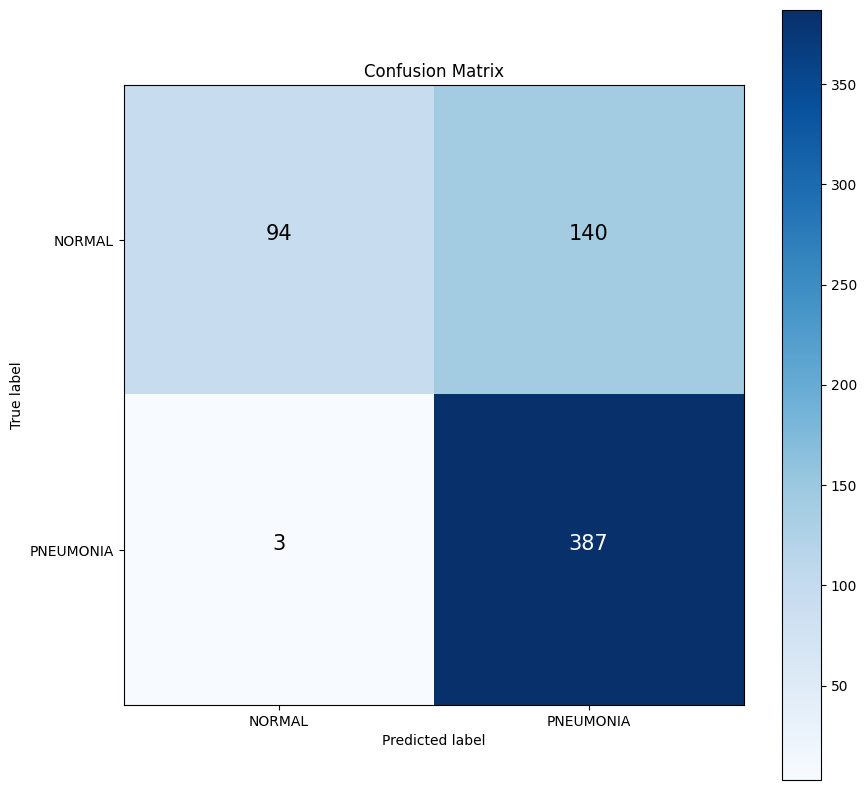

In [ ]:
make_confusion_matrix(
    true_labels,
    predicted_labels,
    classes = test_data.class_names
)

In [ ]:
cm = confusion_matrix(true_labels,predicted_labels)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
print("Specificity:", specificity)
print("Sensitivity:", sensitivity)

Specificity: 0.4017094017094017
Sensitivity: 0.9923076923076923


# `Phase II Conclusion`:
It seems that data augmentation did not improve  the performance of our both model

# `Experimentation Phase III`:

Till now, the ResNet has upper hand over the DenseNet Model. In the upcoming section, I will be now performing transfer learning for fine tuning with decreasing learing rate by `10 times`.


# Model 0.2 : Fine-Tuning ResNet Model

In [ ]:
resnet_base_model = tf.keras.applications.resnet50.ResNet50(weights='imagenet',include_top=False)
resnet_base_model.trainable = False

inputs = layers.Input(shape=(224,224,3),name="input_layer")
x = layers.Rescaling(1./255)(inputs)
x = resnet_base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(1, activation = 'sigmoid', name='output_layer')(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
# Compile 
# Decreasing the learning rate by 10 times
model.compile(loss="binary_crossentropy",
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

# Fit
resnet_base_model_history = model.fit(train_data,
                          epochs = 5,
                          validation_data = val_data,
                          )

Epoch 1/5
163/163 [==============================] - 36s 186ms/step - loss: 0.8155 - accuracy: 0.5878 - val_loss: 0.6689 - val_accuracy: 0.5000
Epoch 2/5
163/163 [==============================] - 31s 182ms/step - loss: 0.3718 - accuracy: 0.8441 - val_loss: 0.5119 - val_accuracy: 0.5625
Epoch 3/5
163/163 [==============================] - 31s 182ms/step - loss: 0.2536 - accuracy: 0.9162 - val_loss: 0.4575 - val_accuracy: 0.6875
Epoch 4/5
163/163 [==============================] - 30s 178ms/step - loss: 0.2032 - accuracy: 0.9339 - val_loss: 0.4370 - val_accuracy: 0.6875
Epoch 5/5
163/163 [==============================] - 31s 177ms/step - loss: 0.1749 - accuracy: 0.9421 - val_loss: 0.4390 - val_accuracy: 0.7500


## `Fine-tuning`

In [ ]:
# Fine tune for 5 more epochs
fine_tune_epochs = 10

history_model_fine_tuned = model.fit(train_data,
                                     epochs=fine_tune_epochs,
                                     validation_data=val_data,
                                     initial_epoch=resnet_base_model_history.epoch[-1],
                                     callbacks=[create_tensorboard_callback("naami", "resnet_model_fine_tuned")])

Saving TensorBoard log files to: naami/resnet_model_fine_tuned/20230505-025303
Epoch 5/10
163/163 [==============================] - 30s 174ms/step - loss: 0.1564 - accuracy: 0.9463 - val_loss: 0.4093 - val_accuracy: 0.7500
Epoch 6/10
163/163 [==============================] - 30s 177ms/step - loss: 0.1434 - accuracy: 0.9505 - val_loss: 0.3836 - val_accuracy: 0.7500
Epoch 7/10
163/163 [==============================] - 31s 183ms/step - loss: 0.1332 - accuracy: 0.9544 - val_loss: 0.4098 - val_accuracy: 0.7500
Epoch 8/10
163/163 [==============================] - 29s 175ms/step - loss: 0.1245 - accuracy: 0.9565 - val_loss: 0.3902 - val_accuracy: 0.7500
Epoch 9/10
163/163 [==============================] - 30s 175ms/step - loss: 0.1179 - accuracy: 0.9580 - val_loss: 0.3867 - val_accuracy: 0.7500
Epoch 10/10
163/163 [==============================] - 30s 178ms/step - loss: 0.1117 - accuracy: 0.9605 - val_loss: 0.3636 - val_accuracy: 0.7500


In [ ]:
model.evaluate(test_data)

20/20 [==============================] - 4s 154ms/step - loss: 0.4074 - accuracy: 0.8029


[0.4074365794658661, 0.8028846383094788]

## `Loss Curves`

In [ ]:
def compare_history(original_history, new_history, initial_epochs=5):
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  val_acc = new_history.history["val_accuracy"]
  val_loss = new_history.history["val_loss"]

  # Combine original history
  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  # Combine val history
  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  plt.figure(figsize=(8,8))
  plt.subplot(2, 1, 1)
  plt.plot(total_acc, label="Training Accuracy")
  plt.plot(total_val_acc, label = "Val Accuracy")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuninig")
  plt.legend(loc="lower right")
  plt.title("Training and Validation Accuracy")

  plt.figure(figsize=(8,8))
  plt.subplot(2, 1, 2)
  plt.plot(total_loss ,label="Training Loss")
  plt.plot(total_val_loss, label = "Val Loss")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuninig")
  plt.legend(loc="upper right")
  plt.title("Training and Validation Loss")

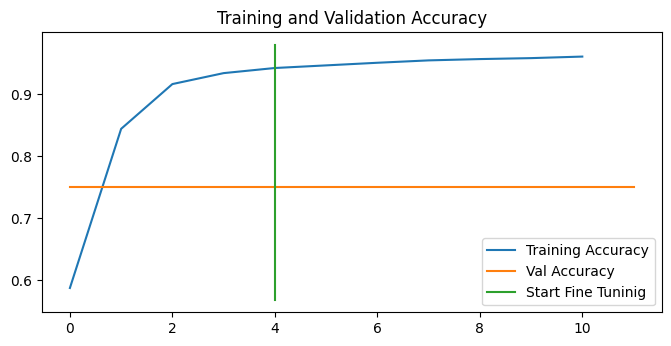

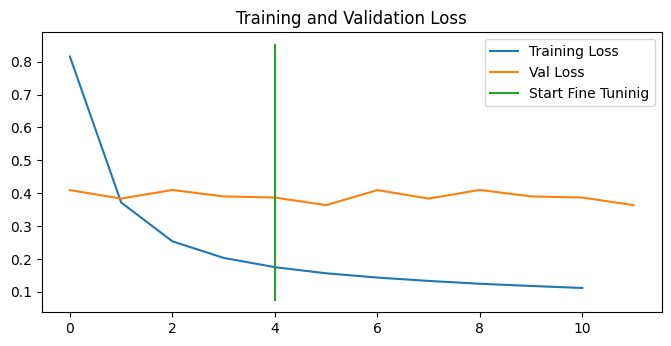

In [ ]:
compare_history(
    resnet_base_model_history,
    history_model_fine_tuned,
    5
) 

## `Evaluation Metrics`

In [ ]:
predictions = model.predict(test_data)
predicted_labels = [0 if prediction < 0.5 else 1 for prediction in predictions]

20/20 [==============================] - 4s 132ms/step


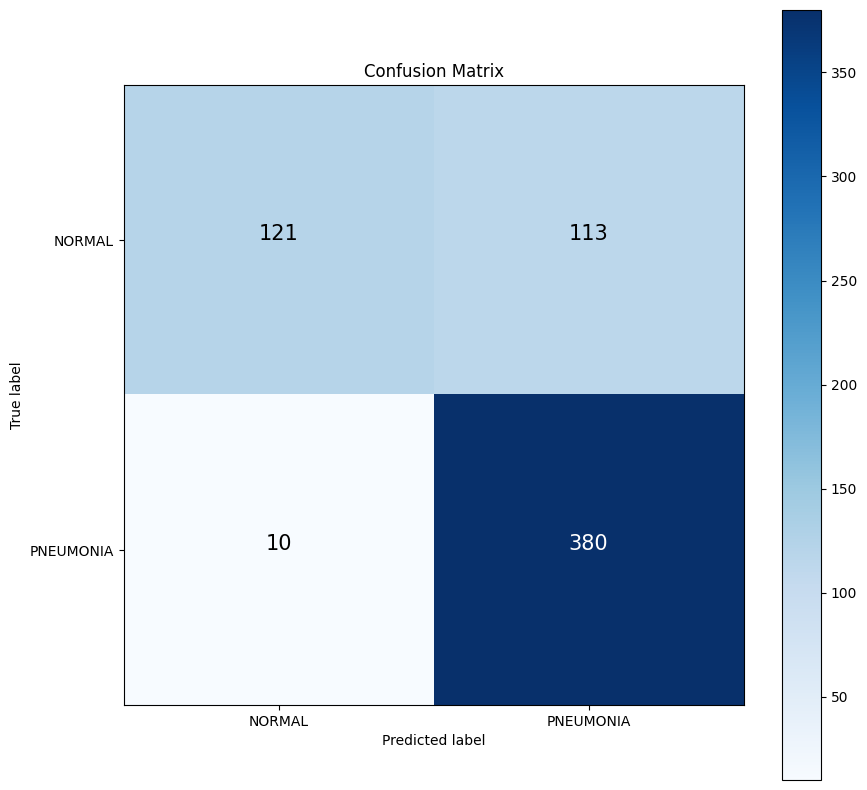

In [ ]:
make_confusion_matrix(
    true_labels,
    predicted_labels,
    classes = test_data.class_names
)

In [ ]:
cm = confusion_matrix(true_labels,predicted_labels)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
print("Specificity:", specificity)
print("Sensitivity:", sensitivity)

Specificity: 0.5170940170940171
Sensitivity: 0.9743589743589743


## `Conclusion`

The model have high sensitity (TPR) but low specificity (TNR). This means that the model is good at identifying positive cases of penumonia but also is classifiying some false positives (i.e normal cases that are incorrectly classified as pneumonia)

# `EXPERIMENT PHASE III Conclusion:`
 

# `Experimentation Phase IV:` 
In the upcoming section, I will be trying out data augmentation along with fine tuning the ResNet model.

# `Model 0.3: Fine-Tuning ResNet model with Data Augmentation` 

In [ ]:
resnet_base_model = tf.keras.applications.resnet50.ResNet50(weights='imagenet',include_top=False)
resnet_base_model.trainable = False

inputs = layers.Input(shape=(224,224,3),name="input_layer")
x = data_augmentation(inputs)
x = resnet_base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(1, activation = 'sigmoid', name='output_layer')(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
# Compile 
model.compile(loss="binary_crossentropy",
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

# Fit
resnet_base_model_history = model.fit(train_data,
                          epochs = 5,
                          validation_data = val_data,
                          )

Epoch 1/5
163/163 [==============================] - 34s 179ms/step - loss: 0.4200 - accuracy: 0.8100 - val_loss: 0.5095 - val_accuracy: 0.6250
Epoch 2/5
163/163 [==============================] - 29s 174ms/step - loss: 0.2332 - accuracy: 0.9202 - val_loss: 0.4976 - val_accuracy: 0.6875
Epoch 3/5
163/163 [==============================] - 30s 175ms/step - loss: 0.1819 - accuracy: 0.9354 - val_loss: 0.5100 - val_accuracy: 0.6875
Epoch 4/5
163/163 [==============================] - 31s 175ms/step - loss: 0.1567 - accuracy: 0.9433 - val_loss: 0.4648 - val_accuracy: 0.6875
Epoch 5/5
163/163 [==============================] - 29s 173ms/step - loss: 0.1404 - accuracy: 0.9494 - val_loss: 0.4632 - val_accuracy: 0.6875


In [ ]:
# Fine tune for 5 more epochs
fine_tune_epochs = 10

history_model_fine_tuned = model.fit(train_data,
                                     epochs=fine_tune_epochs,
                                     validation_data=val_data,
                                     initial_epoch=resnet_base_model_history.epoch[-1],
                                     callbacks=[create_tensorboard_callback("naami", "resnet_model_data_aug_fine_tuned")])

In [ ]:
model.evaluate(test_data)

## `Evaluation Metrics`

In [ ]:
predictions = model.predict(test_data)
predicted_labels = [0 if prediction < 0.75 else 1 for prediction in predictions]

In [ ]:
make_confusion_matrix(
    true_labels,
    predicted_labels,
    classes = test_data.class_names
)

In [ ]:
cm = confusion_matrix(true_labels,predicted_labels)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
print("Specificity:", specificity)
print("Sensitivity:", sensitivity)

## `ROC Curves`

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(true_labels, predictions)

sensitivity = tpr
specificity = 1 - fpr

# plot sensitivity and specificity against threshold

plt.plot(thresholds, sensitivity, label='Sensitivity')
plt.plot(thresholds, specificity, label='Specificity')
plt.xlabel('Threshold')
plt.ylabel('Rate')
plt.legend()
plt.show()

## `Conclusion`:

Here, we can conclude that fine-tuning the ResNet model and  data augmentating somewhat help the performance of the model but it still underperforms than that of the only fine-tuned ResNet model.

# `Visualizing Predictions on Test Images`

In [ ]:
# Create a function to load and prepare images
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
    Reads in an image from filename, turns it into a tensor and reshapes into 
    specified shape
  """
  # Read the image
  img = tf.io.read_file(filename)

  # Decode image into tensor
  img = tf.io.decode_image(img, channels=3)

  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])

  if scale:
    return img/255.
  else:
    return img

In [ ]:
import os
import random

plt.figure(figsize=(17,10))

for i in range(3):
  class_name = random.choice(test_data.class_names)
  filename = random.choice(os.listdir(TEST_DIR + "/" + class_name))
  filepath = TEST_DIR + class_name + "/" + filename

  img = load_and_prep_image(filepath)
  pred_prob = model.predict(tf.expand_dims(img,axis=0))
  if pred_prob < 0.5:
    pred_class = "NORMAL"
  else:
    pred_class = "PENUMONIA"
  
  plt.subplot(1, 3, i+1)
  plt.imshow(img)
  if class_name == pred_class:
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual:{class_name}, pred:{pred_class}, prob = {pred_prob}", c=title_color)
  plt.axis(False);

# `Class Activation Map`

In [ ]:
# Conclusion

# `References`
>* https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0256630
* https://www.tensorflow.org/api_docs